In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor



### Function to Train and Evaluate

In [5]:

def evaluate_models(data, version_name):
    X = data.drop(columns=['Price'])
    y = np.log(data['Price']) 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)
    
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=3, max_samples=0.5, max_features=0.75, max_depth=15),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5),
        'ExtraTrees': ExtraTreesRegressor(n_estimators=100, random_state=3, max_samples=0.5, bootstrap=True, max_features=0.75, max_depth=15)
    }
    
    results = []
    
    for name, model in models.items():
        step1 = ColumnTransformer(transformers=[
            ('col_tnf', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), categorical_features)
        ], remainder='passthrough')
        
        pipe = Pipeline([
            ('step1', step1),
            ('step2', model)
        ])
        
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        results.append({
            'Model': name,
            'Version': version_name,
            'R2 Score': r2,
            'MAE': mae,
            'Pipeline': pipe
        })
        
    return results

In [6]:
# Load versions
v1_df = pd.read_csv('../Data/Processed/v1_preprocessed.csv')
v2_df = pd.read_csv('../Data/Processed/v2_engineered.csv')

In [7]:
# Get results
results_v1 = evaluate_models(v1_df, 'V1 (Basic)')
results_v2 = evaluate_models(v2_df, 'V2 (Engineered)')

# Combine and compare
all_results = pd.DataFrame(results_v1 + results_v2)

In [8]:
# Find best model
best_row = all_results.sort_values(by='R2 Score', ascending=False).iloc[0]
best_model_name = best_row['Model']
best_version = best_row['Version']
best_pipeline = best_row['Pipeline']

In [9]:
# Save results for output
summary = all_results[['Model', 'Version', 'R2 Score', 'MAE']]
summary.to_csv('../TrainedModels/model_comparison_results.csv', index=False)

# Save the best model
with open('../TrainedModels/best_laptop_price_model.pkl', 'wb') as f:
    pickle.dump(best_pipeline, f)

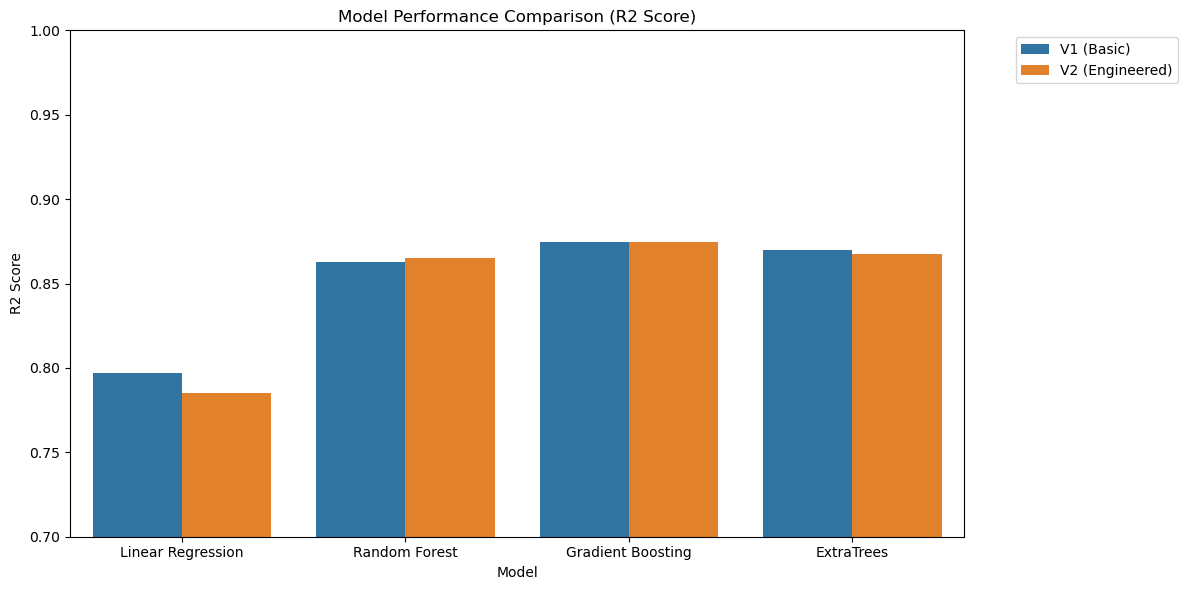

In [10]:
# Plot performance comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=all_results, x='Model', y='R2 Score', hue='Version')
plt.title('Model Performance Comparison (R2 Score)')
plt.ylim(0.7, 1.0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../Data/Assets/model_comparison.png')

In [11]:
print(summary)
print(f"\nBest Overall: {best_model_name} on {best_version}")

               Model          Version  R2 Score       MAE
0  Linear Regression       V1 (Basic)  0.796705  0.204760
1      Random Forest       V1 (Basic)  0.862768  0.166504
2  Gradient Boosting       V1 (Basic)  0.874463  0.160998
3         ExtraTrees       V1 (Basic)  0.869916  0.163774
4  Linear Regression  V2 (Engineered)  0.784896  0.208117
5      Random Forest  V2 (Engineered)  0.865414  0.168285
6  Gradient Boosting  V2 (Engineered)  0.874787  0.161799
7         ExtraTrees  V2 (Engineered)  0.867305  0.163853

Best Overall: Gradient Boosting on V2 (Engineered)
